In [1]:
import pandas as pd
import numpy as np

# Read the initial dataset
df = pd.read_csv('Full_dataset.csv')

# Expected layer height
expected_layer_height = 12.5  # in mm

# List of possible layer columns (from Layer 1 to Layer 10)
layer_columns = [f'Layer {i} Height (mm)' for i in range(1, 11)]

# Convert 'layer' columns to numeric and fill missing values
for col in layer_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Determine the number of layers for each sample
def determine_num_layers(row):
    # If Layer 6 Height is greater than zero, it's a 10-layer sample
    for i in range(10, 0, -1):  # Check from Layer 10 to Layer 1
        if row[f'Layer {i} Height (mm)'] > 0:
            return i
    return 0  # If no layers have height > 0

df['num_layers'] = df.apply(determine_num_layers, axis=1)

# Calculate Expected Total Height per sample
df['expected_total_height'] = df['num_layers'] * expected_layer_height

# Calculate Measured Total Height per sample
def calculate_measured_total_height(row):
    num_layers = int(row['num_layers'])
    layer_cols = [f'Layer {i} Height (mm)' for i in range(1, num_layers + 1)]
    return row[layer_cols].sum()

df['measured_total_height'] = df.apply(calculate_measured_total_height, axis=1)

# Compute Total Print Deviation (in mm)
df['total_print_deviation'] = abs(df['measured_total_height'] - df['expected_total_height'])

# Compute Deposition Ratio
df['deposition_ratio'] = df['Flowrate (Hz)'] / df['Speed (mm/s)']

# Compute Absolute Deviation per Layer
for i in range(1, 11):
    layer_col = f'Layer {i} Height (mm)'
    deviation_col = f'Layer {i} Deviation (mm)'
    df[deviation_col] = df.apply(
        lambda row: abs(row[layer_col] - expected_layer_height) if i <= row['num_layers'] else np.nan,
        axis=1
    )

# Compute Coefficient of Variation (CV) of Layer Heights
def calculate_cv(row):
    num_layers = int(row['num_layers'])
    layer_cols = [f'Layer {i} Height (mm)' for i in range(1, num_layers + 1)]
    layer_heights = row[layer_cols]
    if layer_heights.mean() != 0:
        return (layer_heights.std() / layer_heights.mean()) * 100
    else:
        return 0

df['layer_height_cv'] = df.apply(calculate_cv, axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv('data_with_metrics.csv', index=False)

print("Metrics have been computed and saved to 'data_with_metrics.csv'.")


Metrics have been computed and saved to 'data_with_metrics.csv'.


In [113]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from sklearn.utils import shuffle

# Read the dataset with computed metrics
df = pd.read_csv('data_with_metrics.csv')

# Define features and target variable
features = ['Speed (mm/s)', 'Flowrate (Hz)', 'deposition_ratio']
target = 'layer_height_cv'

X = df[features]
y = df[target]

# Ensure features are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Handle missing values
X = X.fillna(method='ffill')
y = y.fillna(method='ffill')

# Define the number of synthetic samples to generate
original_size = len(X)
target_size = original_size * 10  # Make dataset 5 times larger
num_synthetic_samples = target_size - original_size

# Function to generate synthetic data using noise
def generate_synthetic_data(X, y, num_samples, noise_level=0.05):
    synthetic_X_list = []
    synthetic_y_list = []
    
    for _ in range(num_samples):
        # Randomly select a data point
        idx = np.random.randint(0, X.shape[0])
        x_original = X.iloc[idx]
        y_original = y.iloc[idx]
        
        # Add noise to the features
        x_noisy = x_original.copy()
        for column in X.columns:
            std_dev = X[column].std()
            noise = np.random.normal(0, noise_level * std_dev)
            x_noisy[column] += noise
        
        # Optionally, add noise to the target variable as well
        y_noisy = y_original  # Keeping the target the same or you can add noise
        
        # Append to synthetic data lists
        synthetic_X_list.append(x_noisy)
        synthetic_y_list.append(y_noisy)
    
    # Convert lists to DataFrame and Series
    synthetic_X = pd.DataFrame(synthetic_X_list, columns=X.columns)
    synthetic_y = pd.Series(synthetic_y_list, name=y.name)
    
    return synthetic_X, synthetic_y

# Function to generate synthetic data using interpolation
def generate_interpolated_data(X, y, num_samples):
    # Define the number of points per axis
    points_per_axis = int(np.ceil((num_samples ** (1 / X.shape[1]))))
    
    # Define the range for each feature
    feature_ranges = {}
    for column in X.columns:
        feature_ranges[column] = np.linspace(X[column].min(), X[column].max(), points_per_axis)
    
    # Create a grid of feature values
    mesh = np.meshgrid(*[feature_ranges[col] for col in X.columns])
    mesh_flat = [m.flatten() for m in mesh]
    grid_points = np.vstack(mesh_flat).T
    
    # Interpolate target values at the grid points using 'linear' method
    interpolated_y = griddata(points=X.values, values=y.values, xi=grid_points, method='linear')
    
    # Remove any points where interpolation failed (NaNs)
    valid_mask = ~np.isnan(interpolated_y)
    synthetic_X = pd.DataFrame(grid_points[valid_mask], columns=X.columns)
    synthetic_y = pd.Series(interpolated_y[valid_mask], name=y.name)
    
    # Limit the number of synthetic samples to the required amount
    if len(synthetic_X) > num_samples:
        synthetic_X = synthetic_X.sample(n=num_samples, random_state=42)
        synthetic_y = synthetic_y.loc[synthetic_X.index]
    
    return synthetic_X, synthetic_y

# Parameters
noise_level = 0.05  # Adjust the noise level as appropriate
num_synthetic_samples_noise = num_synthetic_samples // 2
num_synthetic_samples_interp = num_synthetic_samples - num_synthetic_samples_noise

# Generate synthetic data using noise
synthetic_X_noise, synthetic_y_noise = generate_synthetic_data(X, y, num_synthetic_samples_noise, noise_level)

# Generate synthetic data using interpolation
synthetic_X_interp, synthetic_y_interp = generate_interpolated_data(X, y, num_synthetic_samples_interp)

# Combine original and synthetic data
X_expanded = pd.concat([X, synthetic_X_noise, synthetic_X_interp], ignore_index=True)
y_expanded = pd.concat([y, synthetic_y_noise, synthetic_y_interp], ignore_index=True)

# Optional: Shuffle the expanded dataset
X_expanded, y_expanded = shuffle(X_expanded, y_expanded, random_state=42)

# Save the expanded dataset to a new CSV file
df_expanded = pd.concat([X_expanded, y_expanded], axis=1)
df_expanded.to_csv('expanded_dataset_cv.csv', index=False)

print(f"Dataset has been expanded to {len(df_expanded)} samples and saved to 'expanded_dataset.csv'.")


Dataset has been expanded to 405 samples and saved to 'expanded_dataset.csv'.


C:\Users\Ahmad\AppData\Local\Temp\ipykernel_16620\1753586537.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_16620\1753586537.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill')


In [114]:
# Select relevant inputs and outputs
df_ml = pd.concat([X_expanded, y_expanded], axis=1)

# Save to a new CSV file
df_ml.to_csv('ml_dataset_cv.csv', index=False)

print("Relevant data for machine learning has been saved to 'ml_dataset.csv'.")


Relevant data for machine learning has been saved to 'ml_dataset.csv'.


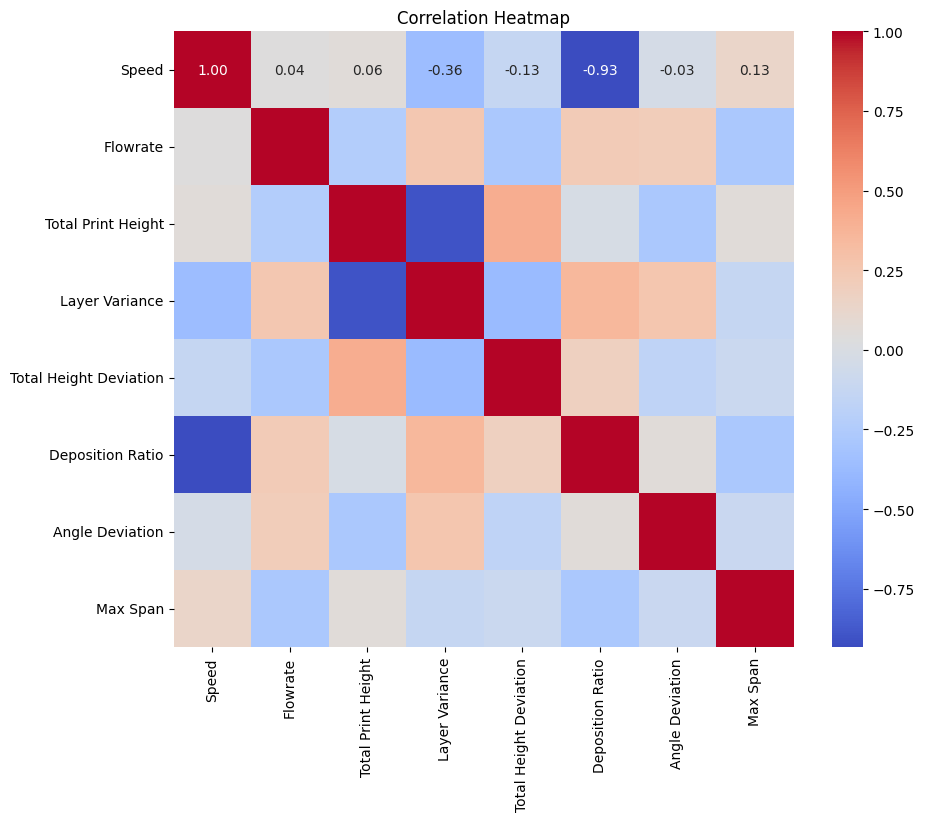

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = 'classified_print_quality.csv'
data = pd.read_csv(file_path)

# Selecting the specified columns for the correlation analysis
columns_of_interest = [
    'Speed (mm/s)', 
    'Flowrate (Hz)', 
    'Total Print Height (mm)', 
    'layer_var',
    'total_height_deviation',
    'deposition_ratio',
    'Angle_dev (deg)',
    'Max Span (mm)'
]

# Renaming the columns for clarity
selected_data = data[columns_of_interest].rename(columns={
    'Speed (mm/s)': 'Speed', 
    'Flowrate (Hz)': 'Flowrate', 
    'Total Print Height (mm)': 'Total Print Height', 
    'layer_var': 'Layer Variance',
    'total_height_deviation': 'Total Height Deviation',
    'deposition_ratio': 'Deposition Ratio',
    'Angle_dev (deg)': 'Angle Deviation',
    'Max Span (mm)': 'Max Span'
})

# Cleaning the data: Removing rows with non-numeric values and converting to floats
selected_data = selected_data.apply(pd.to_numeric, errors='coerce').dropna()

# Calculating the correlation matrix
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 1000x800 with 0 Axes>

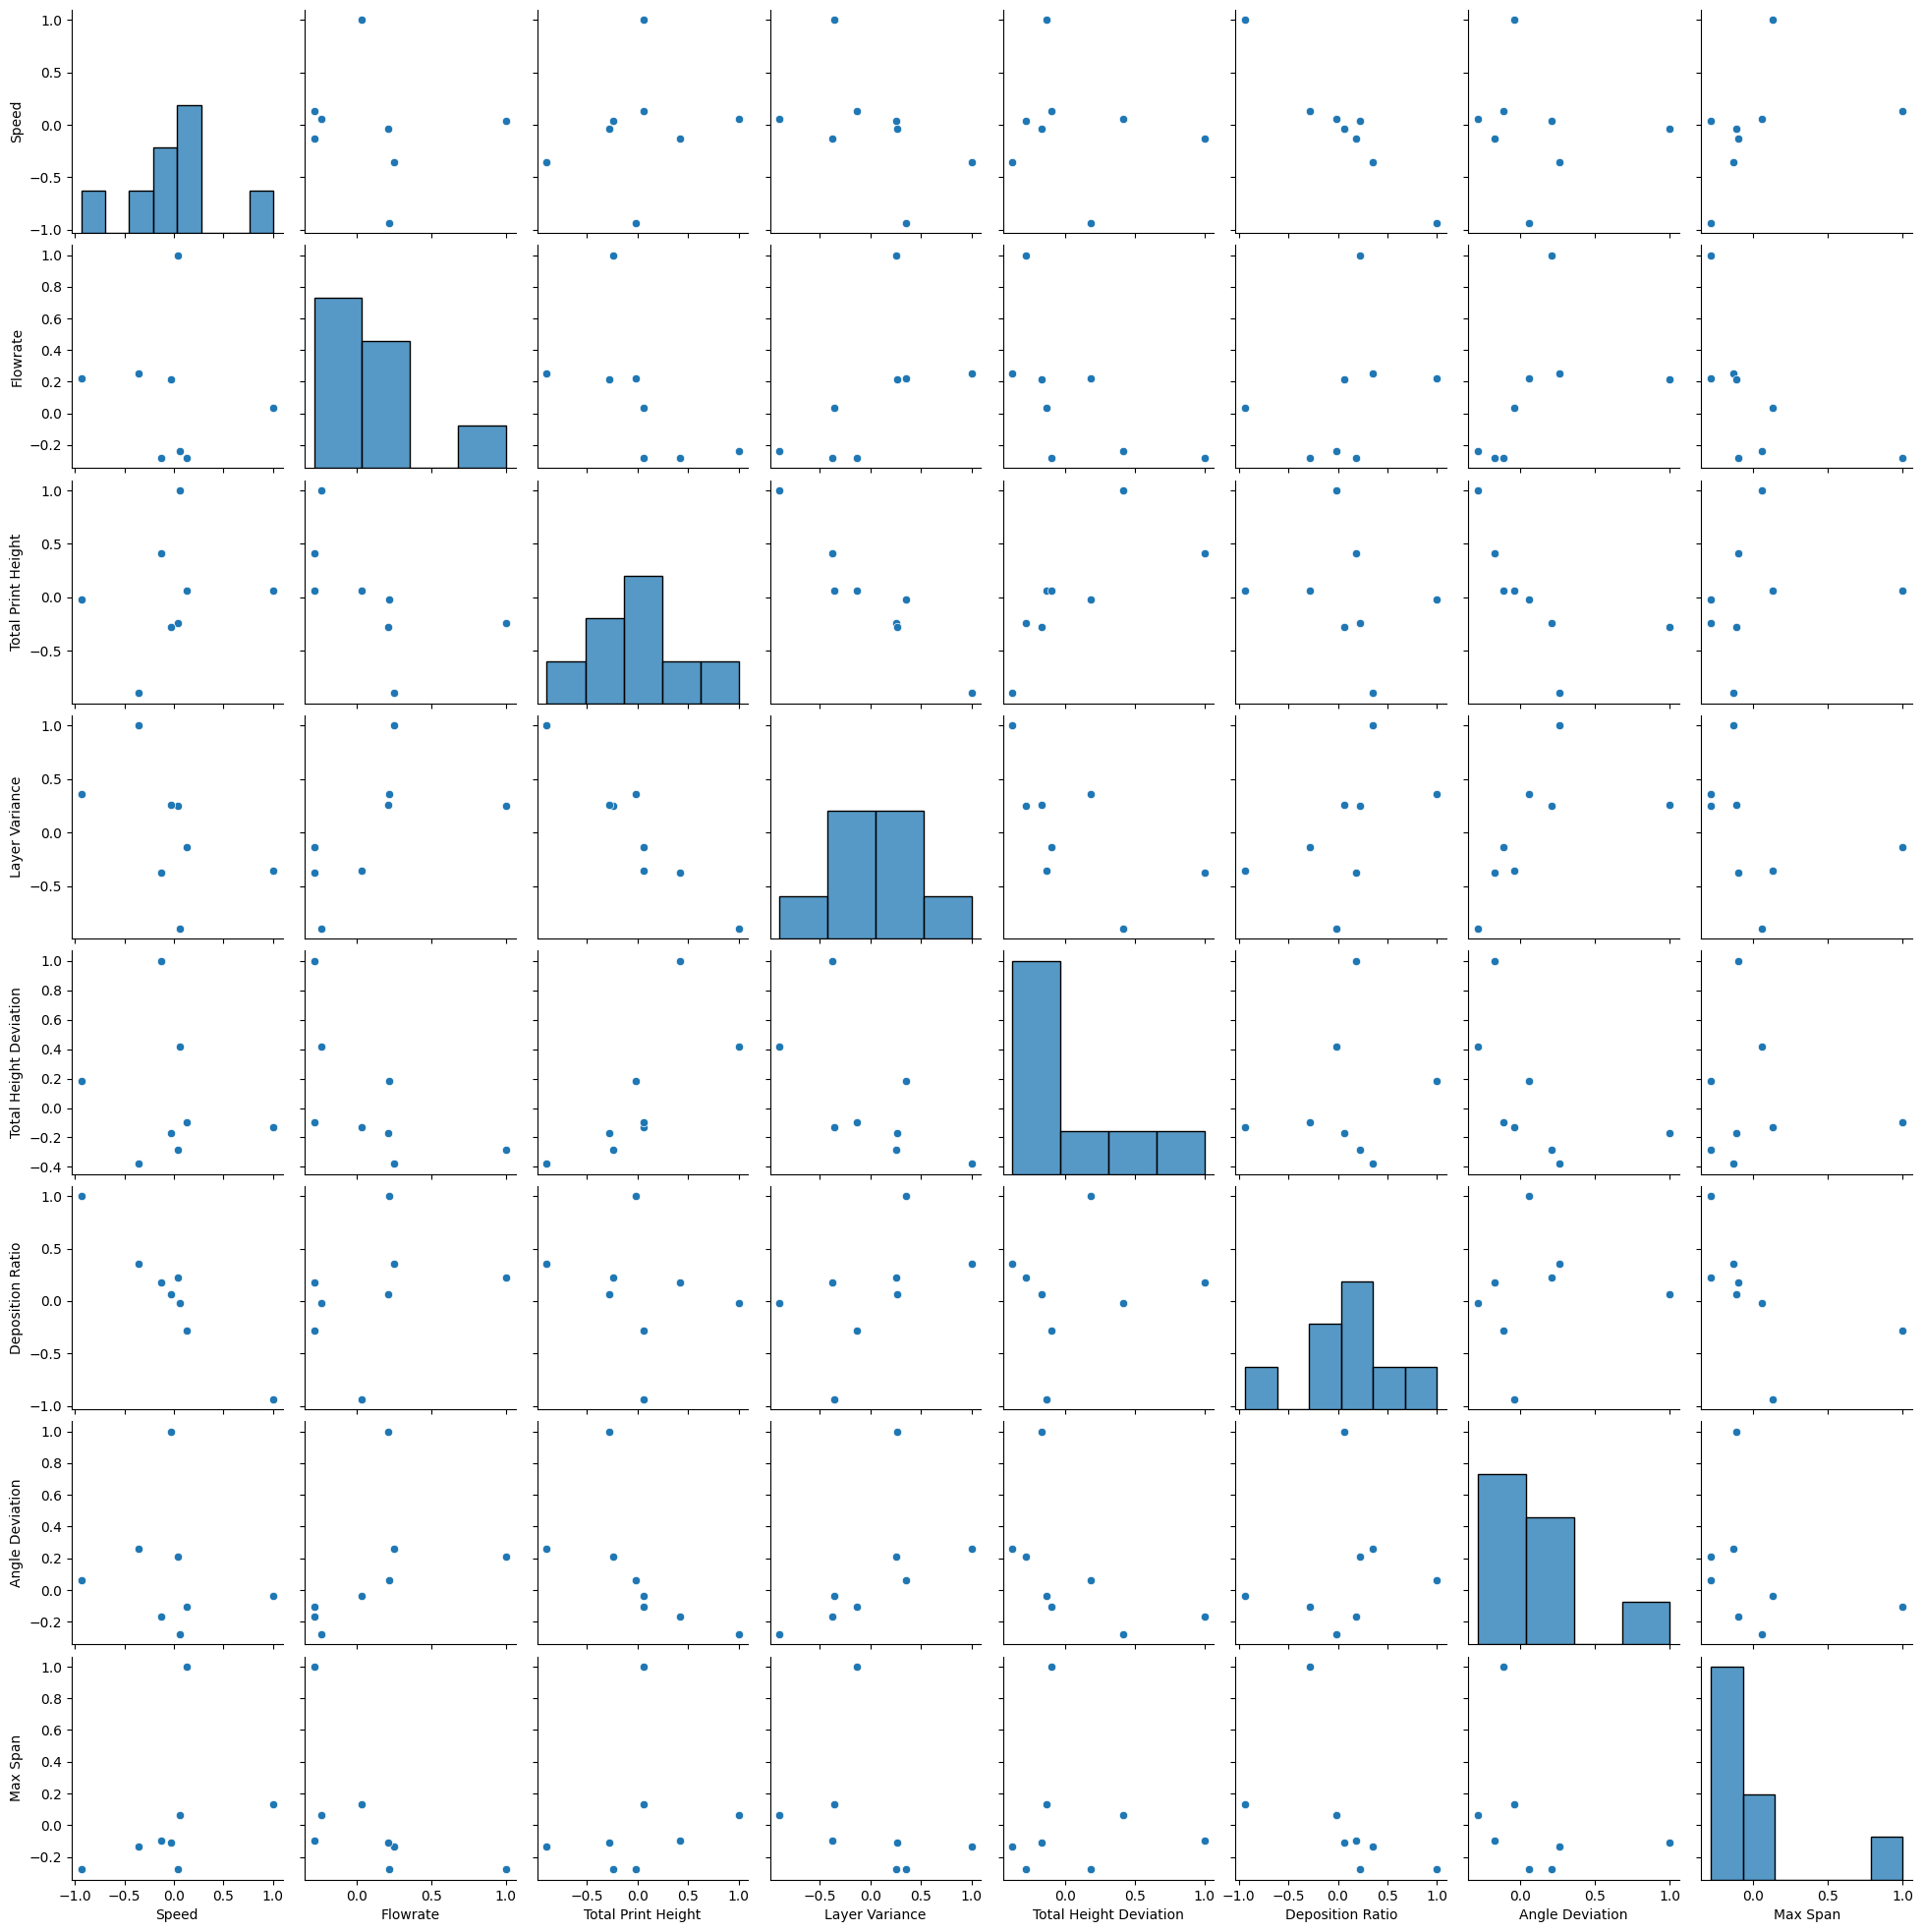

In [11]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.pairplot(correlation_matrix)

plt.show()


C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

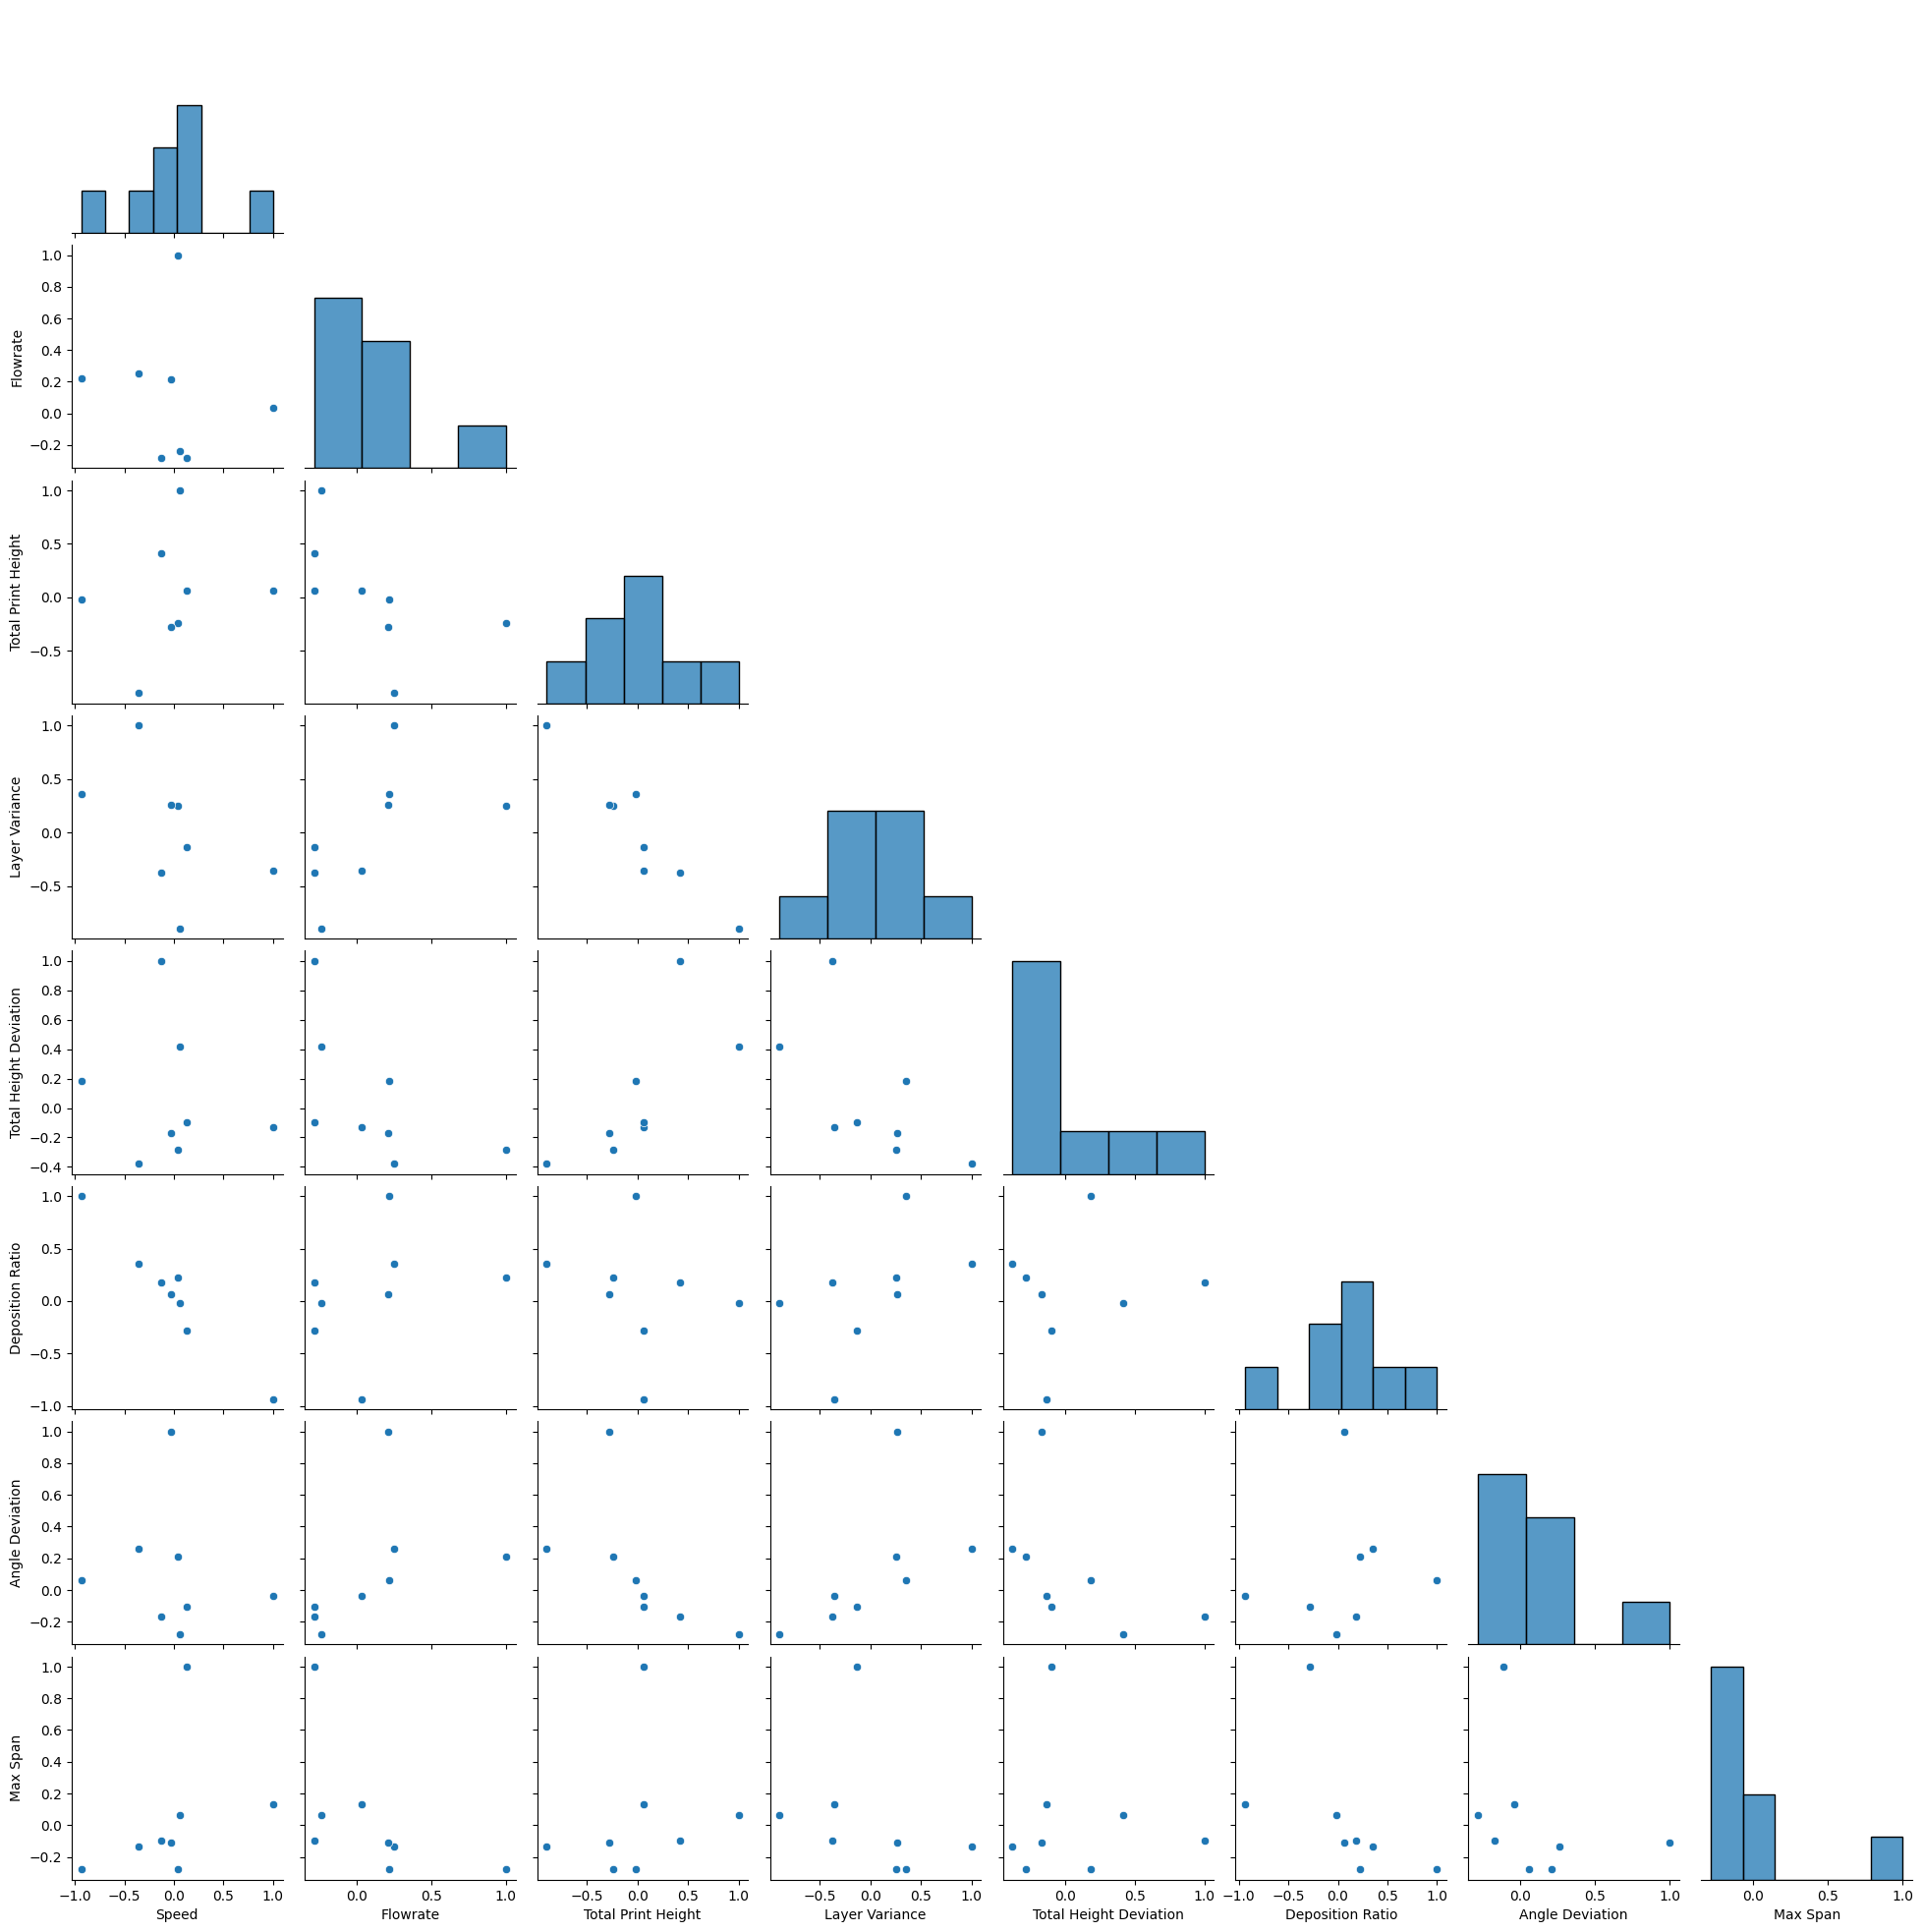

In [14]:
sns.pairplot(correlation_matrix, diag_kind='hist', corner=True)
#plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.savefig('pairplot')
plt.show()

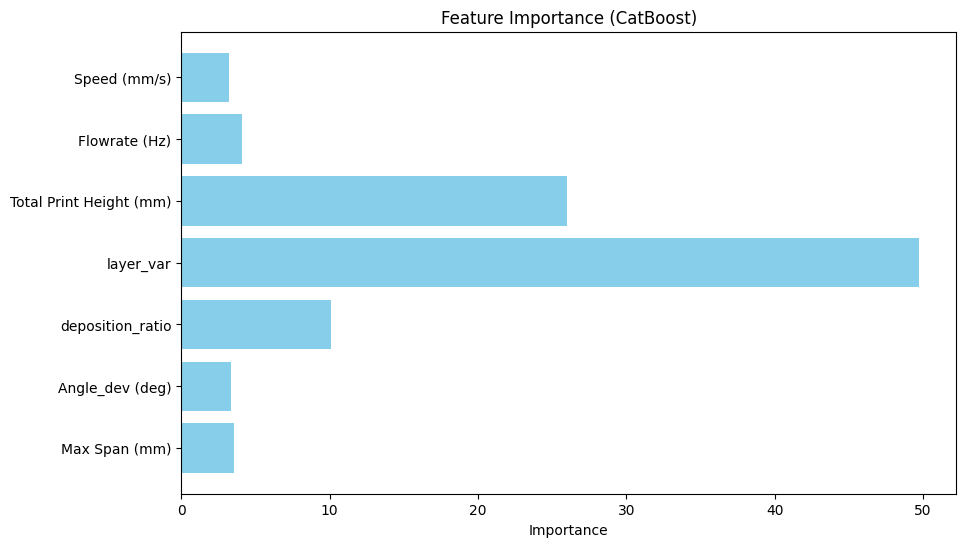

In [16]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'classified_print_quality.csv'
data = pd.read_csv(file_path)

# Selecting features and the target variable
columns_of_interest = [
    'Speed (mm/s)', 
    'Flowrate (Hz)', 
    'Total Print Height (mm)', 
    'layer_var', 
    'deposition_ratio', 
    'Angle_dev (deg)', 
    'Max Span (mm)'
]
target_variable = 'total_height_deviation'

# Prepare the data
X = data[columns_of_interest].apply(pd.to_numeric, errors='coerce').dropna()
y = data[target_variable].apply(pd.to_numeric, errors='coerce').dropna()

# Align indices after dropna
X, y = X.align(y, join='inner', axis=0)

# Define CatBoost model
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0)

# Fit the model
model.fit(X, y)

# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.gca().invert_yaxis()
plt.savefig('feature Importance')
plt.show()
